In [3]:
import math

from openfermionpyscf import run_pyscf
from openfermion.transforms import binary_code_transform, bravyi_kitaev_code, get_fermion_operator
from openfermion.chem import MolecularData
from openfermion.ops import FermionOperator, QubitOperator
from openfermion.utils import count_qubits
from pyscf import gto, scf, mcscf

from helper_functions import *
from XBK_method import *
from QCC_method import *

import time
import statistics as st


In [4]:
#create molecule
name = 'HCONH2'
charge = 0
multiplicity = 1
basis = 'sto-6g'

bond_length = 1.1
geometry = get_molGeometry(name, bond_length)
    
molecule = MolecularData(
    geometry=geometry,
    basis=basis,
    multiplicity=multiplicity,
    charge=charge
)

In [5]:
#run RHF calculations
molecule = run_pyscf(molecule, run_scf=True)
hf_energy = float(molecule.hf_energy)
hf_data = molecule._pyscf_data['scf']

print(hf_energy)

-205.53387517069783


In [6]:
#define active space
n_active_electrons = 2
n_active_orbitals = 3
occupied_indices, active_indices = get_active_space(molecule, n_active_electrons, n_active_orbitals)

#run CASCI calculations
casci_data = hf_data.CASCI(n_active_orbitals, n_active_electrons).run(verbose=False)
casci_energy = float(casci_data.e_tot)

print(casci_energy)

-205.54647301011374


In [7]:
%%capture
#convert to fermionic Hamiltonian
molecular_H = molecule.get_molecular_hamiltonian(occupied_indices=occupied_indices, active_indices=active_indices)
if molecular_H[()] == None:
    molecular_H[()] = 0
fermionic_H = get_fermion_operator(molecular_H)

#add penalty term to ensure correct number of electrons in ground state
weight = 15
penalty_term = FermionOperator('', n_active_electrons)

for i in range(molecular_H.n_qubits):
    penalty_term += FermionOperator(str(i)+'^ '+str(i), -1)
fermionic_H += weight*penalty_term**2

f_operators = list(fermionic_H.get_operators())
print(len(f_operators))
print(fermionic_H)

In [8]:
#%%capture
#convert to Pauli operator Hamiltonian
binary_code = bravyi_kitaev_code(molecular_H.n_qubits)
qubit_H = binary_code_transform(fermionic_H, binary_code)
qubit_H.compress()

#apply symmetry reductions and calculate minimum eigenvalue (should be equal to CASCI energy)
sectors = taper_qubits(qubit_H)
qubit_H, min_eigenvalue = sector_with_ground(sectors)
m = count_qubits(qubit_H)

print(min_eigenvalue, '\n')
operators = list(qubit_H.get_operators())
print(len(operators))
print(m)

-205.5464730101139 

100
4


In [9]:
#set sampler to perform the annealing
from neal import SimulatedAnnealingSampler
sampler = SimulatedAnnealingSampler() #uses simulated annealing, see D-Wave's ocean sdk for more options

In [10]:
### QCC method ###

def QCC_m(angle_folds=3, amplitude_folds=1, num_cycles=10, num_samples=1000, strength=1e3):
    #set number of Bloch angle and entangler amplitude foldings
    #angle_folds = 3
    #amplitude_folds = 1
#    print("Angle folds: ", angle_folds, "\nAmplitude Folds: ", amplitude_folds, 
#          "\nNum cycles: ", num_cycles, "\nStrength: ", strength)

    #create dictionary of QubitOperator entanglers
    entanglers = {'IYZI': QubitOperator('Y1 Z2'), 'IZYI': QubitOperator('Z1 Y2'),
                  'IXYI': QubitOperator('X1 Y2'), 'IYXI': QubitOperator('Y1 X2')}

    #run QCC method
    QCC_energy, variables = QCC(qubit_H, entanglers, angle_folds, amplitude_folds, sampler,
                                num_cycles=num_cycles, num_samples=num_samples, strength=strength)
    return QCC_energy

print("Finished.")
#print(QCC_energy)
#print(variables)

Finished.


In [11]:
def print_results(results):
    print(results)

In [12]:
### Test method ###

def Test(num_cycles=[3,4,5,6,7], num_samples=[100,300,500,700,900], strengths=[1000], runs=5, angle_folds=3, amplitude_folds=1):
    results = []
    for cycle in num_cycles:
        for sample in num_samples:
            for strength in strengths:
                this_time = []
                this_energy = []
                for i in range(0,runs):
                    start_time = time.time()
                    energy = QCC_m(3, 1, cycle, sample, strength)
                    end_time = time.time() - start_time
                    this_energy.append(energy - hf_energy)
                    this_time.append(end_time)
                results.append([cycle, sample, strength, st.mean(this_energy), st.stdev(this_energy), st.mean(this_time), st.stdev(this_time)])
                print("Result ", cycle, sample, strength, " finished.")
    return results

In [13]:
num_cycles=range(1,8)
num_samples=range(50,1050,100)
strengths=[1000]
runs=5

tot_cycles=len(num_cycles)
tot_samples=len(num_samples)
tot_str=len(strengths)
print(tot_cycles)
print(tot_samples)

7
10


In [14]:
from pprint import pprint

results = Test(num_cycles, num_samples, strengths, runs)
pprint(results)

Result  1 50 1000  finished.
Result  1 150 1000  finished.
Result  1 250 1000  finished.
Result  1 350 1000  finished.
Result  1 450 1000  finished.
Result  1 550 1000  finished.
Result  1 650 1000  finished.
Result  1 750 1000  finished.
Result  1 850 1000  finished.
Result  1 950 1000  finished.
Result  2 50 1000  finished.
Result  2 150 1000  finished.
Result  2 250 1000  finished.
Result  2 350 1000  finished.
Result  2 450 1000  finished.
Result  2 550 1000  finished.
Result  2 650 1000  finished.
Result  2 750 1000  finished.
Result  2 850 1000  finished.
Result  2 950 1000  finished.
Result  3 50 1000  finished.
Result  3 150 1000  finished.
Result  3 250 1000  finished.
Result  3 350 1000  finished.
Result  3 450 1000  finished.
Result  3 550 1000  finished.
Result  3 650 1000  finished.
Result  3 750 1000  finished.
Result  3 850 1000  finished.
Result  3 950 1000  finished.
Result  4 50 1000  finished.
Result  4 150 1000  finished.
Result  4 250 1000  finished.
Result  4 350 

[[10.379996378315223, 6.170610147663643, 6.12700660602855, 3.213629651516345, 24.047829363644958, 9.19962644935436, 4.867406655028714, 9.204015373064573, 3.161703000350059, 3.564162352571981], [0.7260397763995172, 0.12734435703455915, 0.03203428979027763, 0.0823386115327196, 0.017456538263610356, 3.0755877795468733, 6.268233098489833, 0.03543399961341152, 3.0889425444867413, 0.04173654462061336], [0.09957756784129401, 0.037584528532130436, 0.00834911443376427, 0.048479362569884187, 0.14572543910322225, 3.0794752806934014, 0.07851599713172278, 0.13884170038941762, 0.05865621372209375, 0.05814742337529992], [0.2436469588384682, -0.011571711827167519, 0.019718077707472047, 0.026296664464422293, 0.0484406153423663, 0.08571361546487992, 0.04843960242429261, 0.026214113694692287, 0.05813534161857774, 0.01416848819640677], [-0.005031498028296255, 1.9891460907164913, -0.011571077503361948, 0.01753902271589709, -0.010547129817172162, -0.01105775687178152, -0.010031179971741721, -0.0115711872248

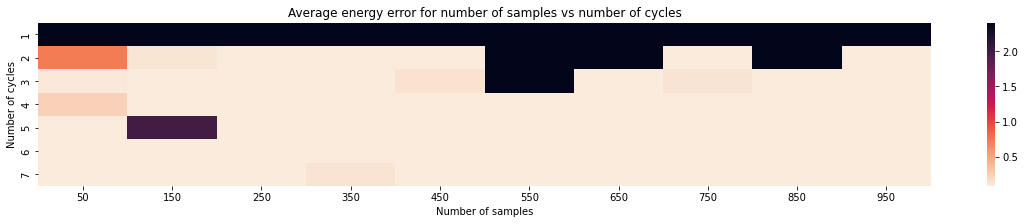

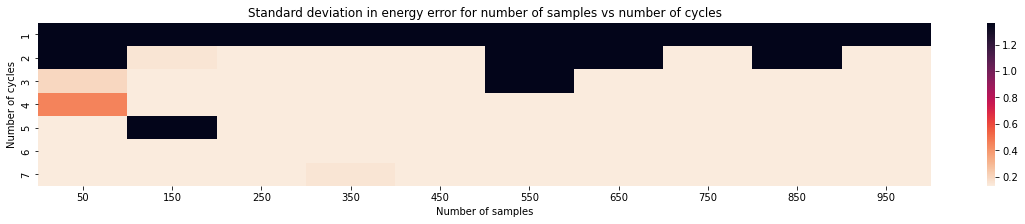

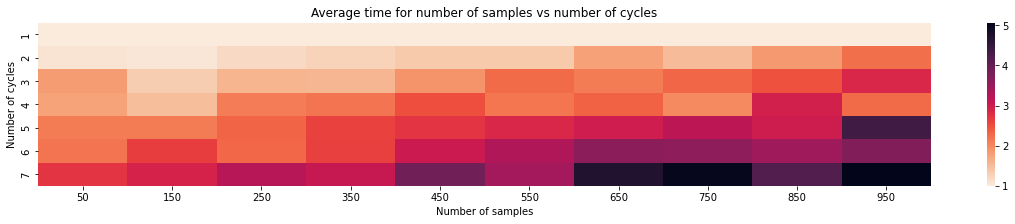

In [17]:
#import sys
#!{sys.executable} -m pip install seaborn
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
cmap = sns.cm.rocket_r
plt.rcParams["figure.figsize"] = (20,3)

def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

def max_value(inputlist):
    return max([max(sublist) for sublist in inputlist])

def min_value(inputlist):
    return min([max(sublist) for sublist in inputlist])

# num cycles vs num samples
# energy mean error

mean_energy_data = list(chunks(([result[3] for result in results[0::tot_str]]),tot_samples))

print(mean_energy_data)

vmax = max_value(mean_energy_data)/10
vmin = min_value(mean_energy_data)
#print(vmax)
#print(vmin)

ax = sns.heatmap(mean_energy_data, vmin=vmin, vmax=vmax, xticklabels=num_samples, yticklabels=num_cycles, cmap=cmap)
plt.xlabel("Number of samples")
plt.ylabel("Number of cycles")
plt.title("Average energy error for number of samples vs number of cycles")
plt.show()

# num cycles vs num samples
# energy stdev
stdev_data = list(chunks(([result[4] for result in results[0::tot_str]]),tot_samples))

#print(stdev_data)

def max_value(inputlist):
    return max([max(sublist) for sublist in inputlist])
def min_value(inputlist):
    return min([max(sublist) for sublist in inputlist])

vmax = max_value(stdev_data)/10
vmin = min_value(stdev_data)
#print(vmax)
#print(vmin)

ax = sns.heatmap(stdev_data, vmin=vmin, vmax=vmax, xticklabels=num_samples, yticklabels=num_cycles, cmap=cmap)
plt.xlabel("Number of samples")
plt.ylabel("Number of cycles")
plt.title("Standard deviation in energy error for number of samples vs number of cycles")
plt.show()

# num cycles vs num samples
# average time
stdev_data = list(chunks(([result[5] for result in results[0::tot_str]]),tot_samples))

#print(stdev_data)

def max_value(inputlist):
    return max([max(sublist) for sublist in inputlist])
def min_value(inputlist):
    return min([max(sublist) for sublist in inputlist])

vmax = max_value(stdev_data)
vmin = min_value(stdev_data)
#print(vmax)
#print(vmin)

ax = sns.heatmap(stdev_data, vmin=vmin, vmax=vmax, xticklabels=num_samples, yticklabels=num_cycles, cmap=cmap)

plt.xlabel("Number of samples")
plt.ylabel("Number of cycles")
plt.title("Average time for number of samples vs number of cycles")
plt.show()

In [28]:
num_cycles=range(1,8)
num_samples=[1000]
strengths=range(10,10010,1000)
tot_cycles=len(num_cycles)
tot_samples=len(num_samples)
tot_str=len(strengths)
print(tot_cycles)
print(tot_str)

7
10


In [29]:
results = Test(num_cycles, num_samples, strengths)
pprint(results)

Result  1 1000 10  finished.
Result  1 1000 1010  finished.
Result  1 1000 2010  finished.
Result  1 1000 3010  finished.
Result  1 1000 4010  finished.
Result  1 1000 5010  finished.
Result  1 1000 6010  finished.
Result  1 1000 7010  finished.
Result  1 1000 8010  finished.
Result  1 1000 9010  finished.
Result  2 1000 10  finished.
Result  2 1000 1010  finished.
Result  2 1000 2010  finished.
Result  2 1000 3010  finished.
Result  2 1000 4010  finished.
Result  2 1000 5010  finished.
Result  2 1000 6010  finished.
Result  2 1000 7010  finished.
Result  2 1000 8010  finished.
Result  2 1000 9010  finished.
Result  3 1000 10  finished.
Result  3 1000 1010  finished.
Result  3 1000 2010  finished.
Result  3 1000 3010  finished.
Result  3 1000 4010  finished.
Result  3 1000 5010  finished.
Result  3 1000 6010  finished.
Result  3 1000 7010  finished.
Result  3 1000 8010  finished.
Result  3 1000 9010  finished.
Result  4 1000 10  finished.
Result  4 1000 1010  finished.
Result  4 1000 2

[[0.702135205711835, 6.171158093695664, 3.1531068088006178, 6.140477088115546, 6.173153755905474, 9.426110079312599, 6.202343335606526, 4.570274805159675, 0.03920739940218141, 9.213947389017227], [-6.53659072580678, 0.013669902602811135, 6.126392272299523, 0.07316228863633682, 6.153696559926862, 0.15154378197472057, 0.10778893884121885, 3.0794702604630912, 0.06930491560920586, 3.0816593539013013], [-13.077679188646965, 0.025249134337315127, 0.0954083858508568, -0.010558075890043029, 0.00732197461907731, 3.096232398306853, 0.007929862778070174, 0.11597618206720313, 0.07652498808307087, 0.008348847388657533], [-5.437216168951164, 3.0939676844499955, 0.00783529517789816, 0.04895393480397274, 0.01753054531141629, 0.013653270968603692, 0.1089593489872243, 0.05814283306095262, 0.03927612125258406, 0.050927438515606126], [-13.441324696905662, 0.02531486971561776, -0.0018706679970307504, 0.00732207258548101, 0.032034284713114404, 0.012627915920126043, 0.07703479134793838, 0.06682049047518035, 

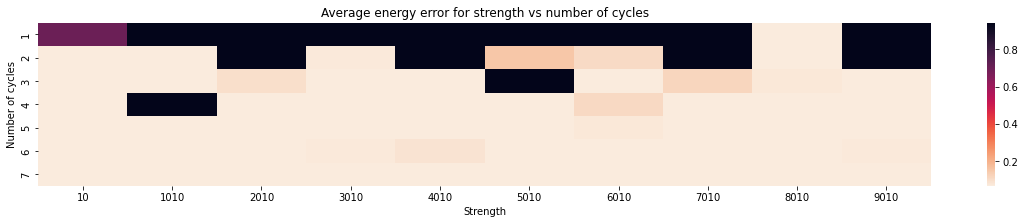

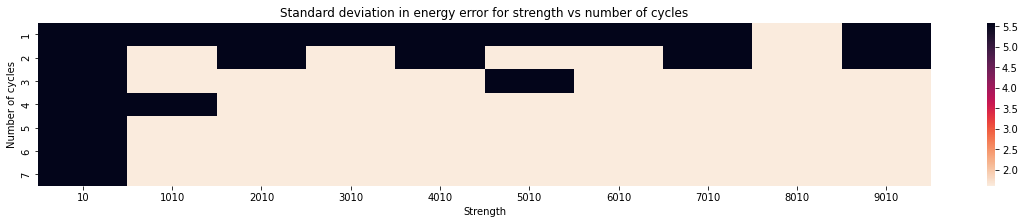

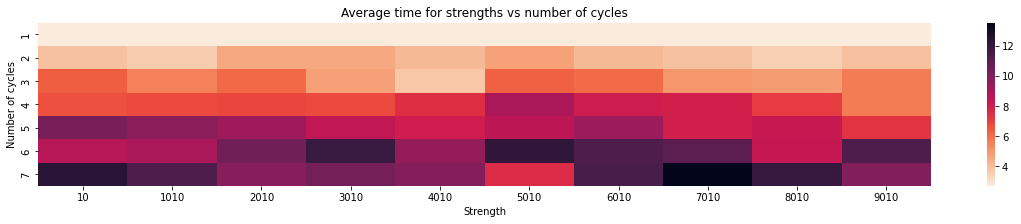

In [32]:
#import sys
#!{sys.executable} -m pip install seaborn
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
cmap = sns.cm.rocket_r
plt.rcParams["figure.figsize"] = (20,3)
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

def max_value(inputlist):
    return max([max(sublist) for sublist in inputlist])

def min_value(inputlist):
    return min([max(sublist) for sublist in inputlist])

# num cycles vs num samples
# energy mean error

mean_energy_data = list(chunks(([result[3] for result in results[0::1]]),tot_str))

print(mean_energy_data)

vmax = max_value(mean_energy_data)/10
vmin = min_value(mean_energy_data)
#print(vmax)
#print(vmin)

ax = sns.heatmap(mean_energy_data, vmin=vmin, vmax=vmax, xticklabels=strengths, yticklabels=num_cycles, cmap=cmap)
plt.xlabel("Strength")
plt.ylabel("Number of cycles")
plt.title("Average energy error for strength vs number of cycles")
plt.show()

# num cycles vs num samples
# energy stdev
stdev_data = list(chunks(([result[4] for result in results[0::1]]),tot_str))

#print(stdev_data)

def max_value(inputlist):
    return max([max(sublist) for sublist in inputlist])
def min_value(inputlist):
    return min([max(sublist) for sublist in inputlist])

vmax = max_value(stdev_data)/10
vmin = min_value(stdev_data)
#print(vmax)
#print(vmin)

ax = sns.heatmap(stdev_data, vmin=vmin, vmax=vmax, xticklabels=strengths, yticklabels=num_cycles, cmap=cmap)
plt.xlabel("Strength")
plt.ylabel("Number of cycles")
plt.title("Standard deviation in energy error for strength vs number of cycles")
plt.show()

# num cycles vs num samples
# average time
stdev_data = list(chunks(([result[5] for result in results[0::1]]),tot_str))

#print(stdev_data)

def max_value(inputlist):
    return max([max(sublist) for sublist in inputlist])
def min_value(inputlist):
    return min([max(sublist) for sublist in inputlist])

vmax = max_value(stdev_data)
vmin = min_value(stdev_data)
#print(vmax)
#print(vmin)

ax = sns.heatmap(stdev_data, vmin=vmin, vmax=vmax, xticklabels=strengths, yticklabels=num_cycles, cmap=cmap)

plt.xlabel("Strength")
plt.ylabel("Number of cycles")
plt.title("Average time for strengths vs number of cycles")
plt.show()

In [34]:
num_cycles=[4]
num_samples=range(10,1010,100)
strengths=range(10,10010,1000)
tot_cycles=len(num_cycles)
tot_samples=len(num_samples)
tot_str=len(strengths)
print(tot_cycles)
print(tot_str)

1
10


In [35]:
results = Test(num_cycles, num_samples, strengths)
pprint(results)

Result  4 10 10  finished.
Result  4 10 1010  finished.
Result  4 10 2010  finished.
Result  4 10 3010  finished.
Result  4 10 4010  finished.
Result  4 10 5010  finished.
Result  4 10 6010  finished.
Result  4 10 7010  finished.
Result  4 10 8010  finished.
Result  4 10 9010  finished.
Result  4 110 10  finished.
Result  4 110 1010  finished.
Result  4 110 2010  finished.
Result  4 110 3010  finished.
Result  4 110 4010  finished.
Result  4 110 5010  finished.
Result  4 110 6010  finished.
Result  4 110 7010  finished.
Result  4 110 8010  finished.
Result  4 110 9010  finished.
Result  4 210 10  finished.
Result  4 210 1010  finished.
Result  4 210 2010  finished.
Result  4 210 3010  finished.
Result  4 210 4010  finished.
Result  4 210 5010  finished.
Result  4 210 6010  finished.
Result  4 210 7010  finished.
Result  4 210 8010  finished.
Result  4 210 9010  finished.
Result  4 310 10  finished.
Result  4 310 1010  finished.
Result  4 310 2010  finished.
Result  4 310 3010  finished

[[-6.322737596526935, 9.97075791889652, 6.117273220430031, 6.213802187632206, 6.082117897875975, 2.2887599820721847, 12.176160949839646, 1.648308212273656, 10.01468356493711, 13.927182985980432], [-12.735318584635655, 6.112809136389075, 0.008273734924983955, -0.0008265062366660913, 1.1595043717984992, 0.044595032672765454, -0.004457089865212538, 0.0262666351379778, 0.12784116256366929, 0.22759863152019194], [-18.24321292335214, -0.010544431845522695, 0.07011994062773397, 0.044594964173990094, 0.06409089935328324, 0.05339736954625209, 0.05292623690179994, 0.008348604406597815, -0.011058565533352294, 0.04997493529077133], [-7.978839166421738, -0.008878178377966606, 0.08624967007049804, 0.0562332726767238, 0.08235366742442807, 0.6998978790113654, 0.007710917245964311, 0.025701755865844687, 0.00949009882602354, 0.007835268856393896], [-9.017303621515515, -0.011057858531461306, 0.03202662678518777, 0.01702523955460151, 0.06165185486748328, 0.007835313169886149, 0.03591742868152892, -0.01106

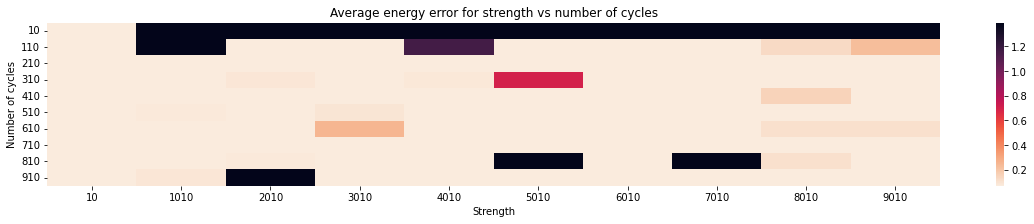

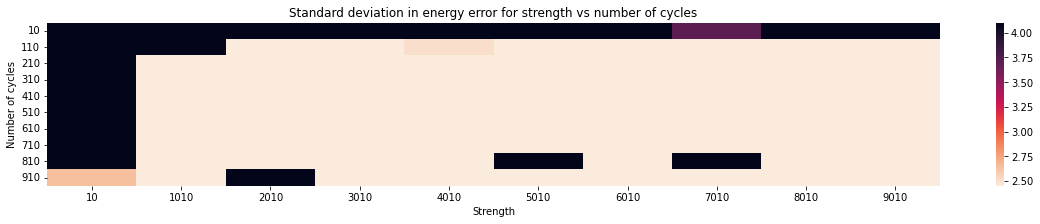

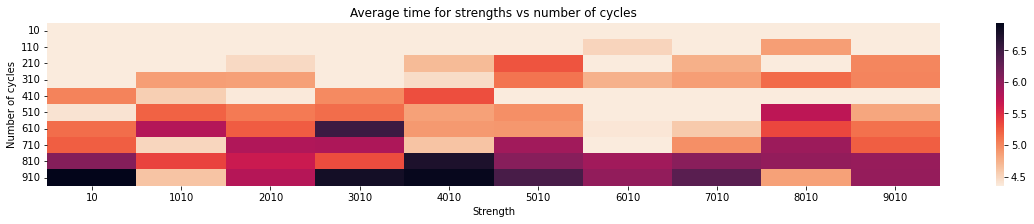

In [37]:
#import sys
#!{sys.executable} -m pip install seaborn
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
cmap = sns.cm.rocket_r
plt.rcParams["figure.figsize"] = (20,3)
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

def max_value(inputlist):
    return max([max(sublist) for sublist in inputlist])

def min_value(inputlist):
    return min([max(sublist) for sublist in inputlist])

# num cycles vs num samples
# energy mean error

mean_energy_data = list(chunks(([result[3] for result in results[0::1]]),tot_str))

print(mean_energy_data)

vmax = max_value(mean_energy_data)/10
vmin = min_value(mean_energy_data)
#print(vmax)
#print(vmin)

ax = sns.heatmap(mean_energy_data, vmin=vmin, vmax=vmax, xticklabels=strengths, yticklabels=num_samples, cmap=cmap)
plt.xlabel("Strength")
plt.ylabel("Number of cycles")
plt.title("Average energy error for strength vs number of cycles")
plt.show()

# num cycles vs num samples
# energy stdev
stdev_data = list(chunks(([result[4] for result in results[0::1]]),tot_str))

#print(stdev_data)

def max_value(inputlist):
    return max([max(sublist) for sublist in inputlist])
def min_value(inputlist):
    return min([max(sublist) for sublist in inputlist])

vmax = max_value(stdev_data)/10
vmin = min_value(stdev_data)
#print(vmax)
#print(vmin)

ax = sns.heatmap(stdev_data, vmin=vmin, vmax=vmax, xticklabels=strengths, yticklabels=num_samples, cmap=cmap)
plt.xlabel("Strength")
plt.ylabel("Number of cycles")
plt.title("Standard deviation in energy error for strength vs number of cycles")
plt.show()

# num cycles vs num samples
# average time
stdev_data = list(chunks(([result[5] for result in results[0::1]]),tot_str))

#print(stdev_data)

def max_value(inputlist):
    return max([max(sublist) for sublist in inputlist])
def min_value(inputlist):
    return min([max(sublist) for sublist in inputlist])

vmax = max_value(stdev_data)
vmin = min_value(stdev_data)
#print(vmax)
#print(vmin)

ax = sns.heatmap(stdev_data, vmin=vmin, vmax=vmax, xticklabels=strengths, yticklabels=num_samples, cmap=cmap)

plt.xlabel("Strength")
plt.ylabel("Number of cycles")
plt.title("Average time for strengths vs number of cycles")
plt.show()

In [ ]:
runs = 10
angle_folds = range(2,10)
this_time = []
this_energy = []
this_fold = []

for fold in angle_folds:
    for i in range(0,runs):
        start_time = time.time()
        energy = QCC_m(fold)
        end_time = time.time() - start_time
        this_energy.append(energy)
        this_time.append(end_time)
    this_fold.append([st.mean(this_energy), st.stdev(this_energy), st.mean(this_time), st.stdev(this_time)])
print(this_fold)


[5.611635605494182, 6.974762201309204, 6.66033042801751, 6.7007946372032166, 7.089831527074178, 7.381799856821696, 7.601418937955584, 7.66414878765742]


<ErrorbarContainer object of 3 artists>

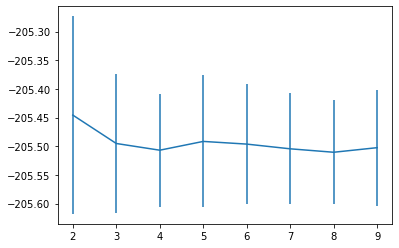

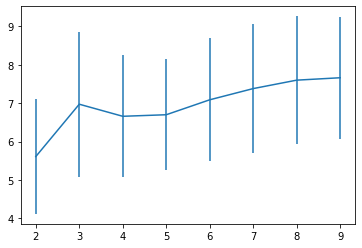

In [52]:
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure()
e = list(item[0] for item in this_fold)
t = list(item[2] for item in this_fold)
eerr = list(item[1] for item in this_fold)
terr = list(item[3] for item in this_fold)

plt.errorbar(angle_folds, e , yerr=eerr, label='both limits (default)')

fig = plt.figure()
plt.errorbar(angle_folds, t, yerr=terr, label='both limits (default)')

Finished run  0
Finished run  1
Finished run  2
Finished cycle  2
Finished run  0
Finished run  1
Finished run  2
Finished cycle  3
Finished run  0
Finished run  1
Finished run  2
Finished cycle  4
Finished run  0
Finished run  1
Finished run  2
Finished cycle  5
Finished run  0
Finished run  1
Finished run  2
Finished cycle  6
Finished run  0
Finished run  1
Finished run  2
Finished cycle  7
Finished run  0
Finished run  1
Finished run  2
Finished cycle  8
Finished run  0
Finished run  1
Finished run  2
Finished cycle  9
Finished run  0
Finished run  1
Finished run  2
Finished cycle  10
Finished run  0
Finished run  1
Finished run  2
Finished cycle  11
Finished run  0
Finished run  1
Finished run  2
Finished cycle  12
Finished run  0
Finished run  1
Finished run  2
Finished cycle  13
Finished run  0
Finished run  1
Finished run  2
Finished cycle  14
[[0.05792421558823927, 0.04147179283528982, 1.7761627038319905, 0.11986929683848825], [0.05428276807749436, 0.039061321138707715, 2.01476

<ErrorbarContainer object of 3 artists>

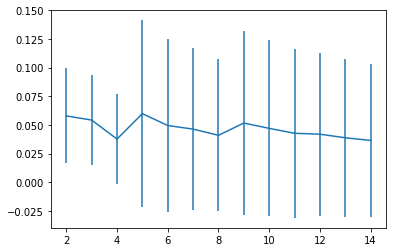

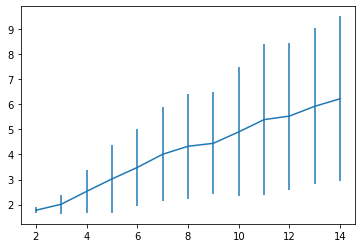

In [14]:
import time
import statistics as st

runs = 3
num_cycles = range(2,15)
this_time = []
this_energy = []
this_fold = []

for cycle in num_cycles:
    for i in range(0,runs):
        start_time = time.time()
        energy = QCC_m(3, 1, cycle)
        end_time = time.time() - start_time
        this_energy.append(abs(energy-hf_energy))
        this_time.append(end_time)
        print("Finished run ", i)
    this_fold.append([st.mean(this_energy), st.stdev(this_energy), st.mean(this_time), st.stdev(this_time)])
    print("Finished cycle ", cycle)
print(this_fold)

fig = plt.figure()
e = list(item[0] for item in this_fold)
t = list(item[2] for item in this_fold)
eerr = list(item[1] for item in this_fold)
terr = list(item[3] for item in this_fold)

plt.errorbar(num_cycles, e , yerr=eerr, label='both limits (default)')

fig = plt.figure()
plt.errorbar(num_cycles, t, yerr=terr, label='both limits (default)')

In [11]:
import time
import statistics as st

runs = 3
num_samples = [5,10,100]
this_time = []
this_energy = []
this_fold = []

for sample in num_samples:
    for i in range(0,runs):
        start_time = time.time()
        energy = QCC_m(3, 1, 10, sample)
        end_time = time.time() - start_time
        this_energy.append(energy)
        this_time.append(end_time)
        print("Finished run ", i)
    this_fold.append([st.mean(this_energy), st.stdev(this_energy), st.mean(this_time), st.stdev(this_time)])
    print("Finished sample ", sample)
print(this_fold)

fig = plt.figure()
e = list(item[0] for item in this_fold)
t = list(item[2] for item in this_fold)
eerr = list(item[1] for item in this_fold)
terr = list(item[3] for item in this_fold)

plt.errorbar(num_samples, e , yerr=eerr, label='both limits (default)')

fig = plt.figure()
plt.errorbar(num_samples, t, yerr=terr, label='both limits (default)')

Finished run  0
Finished run  1
Finished run  2
Finished sample  5
Finished run  0
Finished run  1
Finished run  2
Finished sample  10
Finished run  0
Finished run  1
Finished run  2
Finished sample  100
[[-205.53462803225435, 0.009398253175228079, 5.068637768427531, 0.3662266437613542], [-205.5121678984451, 0.03751887311058555, 5.385236620903015, 1.15400571174611], [-205.52105742621603, 0.03260275907431554, 5.399000326792399, 0.930244336470376]]


NameError: name 'plt' is not defined

<ErrorbarContainer object of 3 artists>

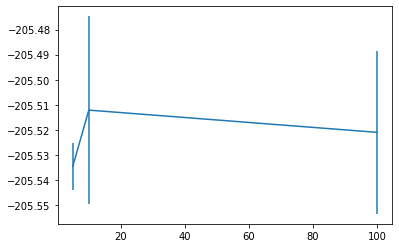

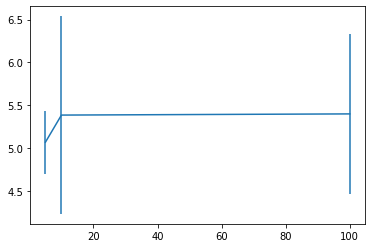

In [12]:
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure()
e = list(item[0] for item in this_fold)
t = list(item[2] for item in this_fold)
eerr = list(item[1] for item in this_fold)
terr = list(item[3] for item in this_fold)

plt.errorbar(num_samples, e , yerr=eerr, label='both limits (default)')

fig = plt.figure()
plt.errorbar(num_samples, t, yerr=terr, label='both limits (default)')

Finished run  0
Finished run  1
Finished run  2
Finished strength  10
Finished run  0
Finished run  1
Finished run  2
Finished strength  100
Finished run  0
Finished run  1
Finished run  2
Finished strength  1000
Finished run  0
Finished run  1
Finished run  2
Finished strength  10000
[[-219.499446727779, 7.921113781051472, 9.739084402720133, 3.355819655255588], [-212.52210397729672, 9.13879601036443, 9.774271130561829, 2.301191489034022], [-210.16298340342746, 8.045379587428947, 9.864960273106893, 2.2959901270589333], [-208.9931111162607, 7.180153532858862, 9.433550715446472, 2.1406134034738296]]


<ErrorbarContainer object of 3 artists>

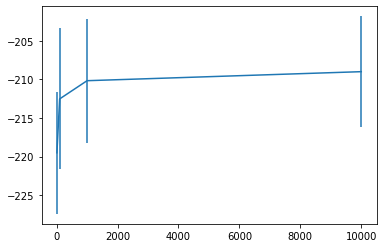

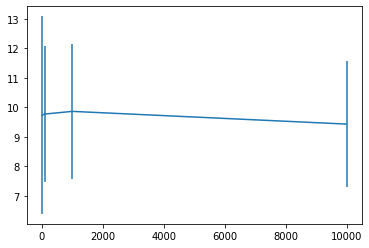

In [64]:
import time
import statistics as st

runs = 3
strengths = [10,100,1000, 10000]
this_time = []
this_energy = []
this_fold = []

for strength in strengths:
    for i in range(0,runs):
        start_time = time.time()
        energy = QCC_m(3, 1, 10, 1000, strength)
        end_time = time.time() - start_time
        this_energy.append(energy)
        this_time.append(end_time)
        print("Finished run ", i)
    this_fold.append([st.mean(this_energy), st.stdev(this_energy), st.mean(this_time), st.stdev(this_time)])
    print("Finished strength ", strength)
print(this_fold)

fig = plt.figure()
e = list(item[0] for item in this_fold)
t = list(item[2] for item in this_fold)
eerr = list(item[1] for item in this_fold)
terr = list(item[3] for item in this_fold)

plt.errorbar(strengths, e , yerr=eerr, label='both limits (default)')

fig = plt.figure()
plt.errorbar(strengths, t, yerr=terr, label='both limits (default)')

In [9]:
### XBK method ###

#set r value
r = 4

#construct qubit Hamiltonians and C terms for XBK method
qubit_Hs, qubit_Cs = [],[]
for p in range(int(math.ceil(r/2+1))):
    qubit_Hs += [XBK_transform(qubit_H, r, p)]
    qubit_Cs += [construct_C(m, r, p)]

#run XBK method
XBK_energy, ground_state = XBK(qubit_Hs, qubit_Cs, r, sampler, starting_lam=0, num_samples=1000, strength=1e3, verbose=False)

print(XBK_energy)
print(ground_state) #ground state in rm-qubit space

-205.54390640792067
[1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0]
